In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir
from geo_tool import Point_Cloud

In [4]:
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers,\
latent_code_generator_two_layers

from tf_lab.gans.vanilla_gan import Vanilla_GAN
from tf_lab.gans.w_gan_gp import W_GAN_GP

In [13]:
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [24]:
from tf_lab.in_out.basics import read_saved_epochs

In [39]:

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.convenience import get_latent_codes


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
n_pc_points = 2048
do_training = True
plot_train_curve = True 
save_synthetic_samples = False
save_model = False
max_epochs = 500

class_name = 'chair'
# class_name = raw_input('Give me the class type.\n').lower()

save_syn_step = 100
saver_syn_step = np.hstack([np.array([1, 5, 10]), 
                            np.arange(save_syn_step, max_epochs + 1, 
                                      save_syn_step)])


syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'chamfer'
do_wgan = False
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
special_tag = None

Give me bneck_size.
128


In [18]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_experiment_tag, ae_loss, 'bneck', str(b_neck)])

if special_tag is not None:
    experiment_tag += '_' + special_tag

print experiment_tag

l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128


In [19]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_data = in_data['train']

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [20]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples_new/', gan_tag, experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128'

In [30]:
# Load Auto-Encoder
ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))

saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step

In [31]:
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_2048_pts_128_bneck_chamfer/models.ckpt-500
Model restored in epoch 500.


In [40]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [41]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
beta = 0.5
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [34]:
reset_tf_graph()

if do_wgan:
    lam = 10
    gan = W_GAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                  latent_code_discriminator_two_layers, 
                  latent_code_generator_two_layers,\
                  beta=beta
                 )
else:    
    gan = Vanilla_GAN(experiment_tag, init_lr, n_out, noise_dim,
                     latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                     beta=beta
                    )

1 (0.7447642220103222, 0.8752635064332381)
2 (0.30188763970914095, 1.65980413167373)
3 (0.30466322017752606, 2.029414838293324)
4 (0.7959535171156344, 1.5330167210620382)
5 (1.1931294420491094, 1.1941844530727552)
6 (1.0992564735205277, 1.1970059674719105)
7 (0.9101749586022418, 1.3215048022892164)
8 (0.8209975854210232, 1.4658101900764133)
9 (0.855537634310515, 1.4755227037098098)
10 (0.8900282740592956, 1.3643935493800952)


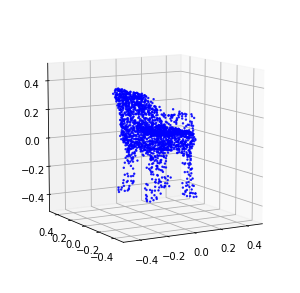

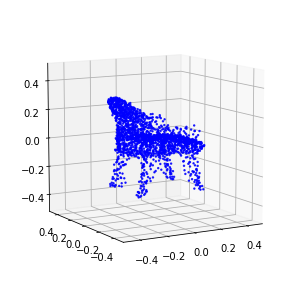

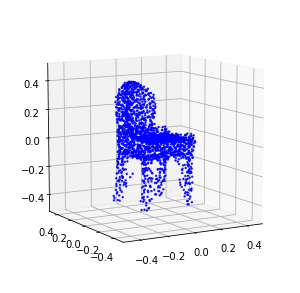

11 (0.8933053934055826, 1.2524518640145013)
12 (0.925644772467406, 1.1746954264848128)
13 (1.001968633091968, 1.1080871794534766)
14 (1.0748175823170205, 1.0492916247119075)
15 (1.1446197551229726, 0.9916833779086237)
16 (1.1865567974422289, 0.9580819487571717)
17 (1.1970004076543062, 0.9439524681671806)
18 (1.209380662959555, 0.9206716656684876)
19 (1.228071981927623, 0.900532763418944)
20 (1.2217980001283728, 0.8933853838754737)


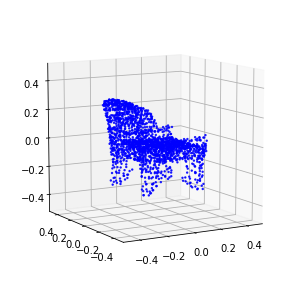

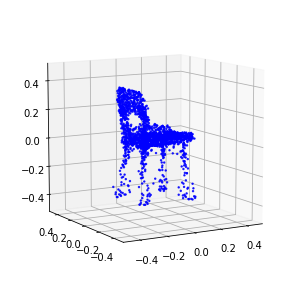

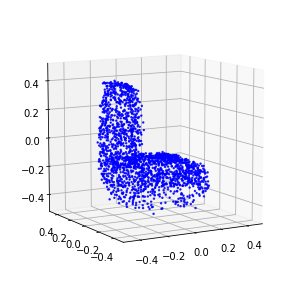

21 (1.210894313065902, 0.900837212541829)
22 (1.2146738674329676, 0.894427067818849)
23 (1.2096879534099414, 0.8941420715788136)
24 (1.193937287123307, 0.9050728834193685)
25 (1.2008430605349334, 0.898023271560669)
26 (1.204597236799157, 0.8918588021527166)
27 (1.2151105621586675, 0.8935644533323205)
28 (1.2264432067456452, 0.8799723588902018)
29 (1.247139945237533, 0.8727991482485895)
30 (1.266358084264009, 0.8609015024226645)


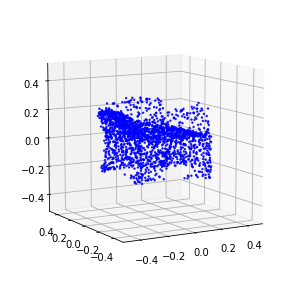

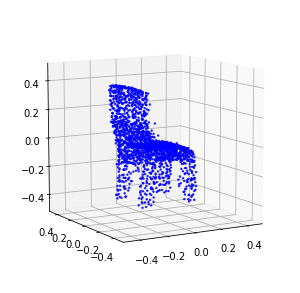

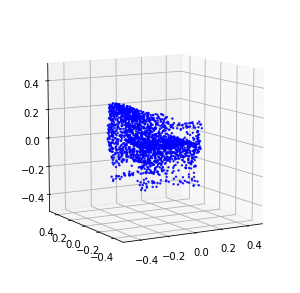

31 (1.290323507267496, 0.8416958057362101)
32 (1.29900686637215, 0.8284376330997633)
33 (1.2985678994137309, 0.8217334083888842)
34 (1.2885163794393124, 0.8216639757156372)
35 (1.288674453030462, 0.8122002694917762)
36 (1.2802908016287762, 0.8103275584137958)
37 (1.268077912537948, 0.8174021078192669)
38 (1.2606874714726988, 0.8302066300226294)
39 (1.253972573902296, 0.8390108621638754)
40 (1.2446713540865026, 0.8465362880540931)


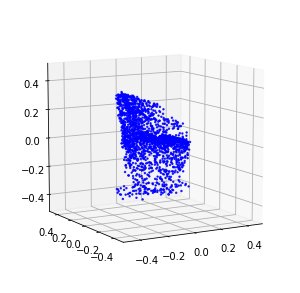

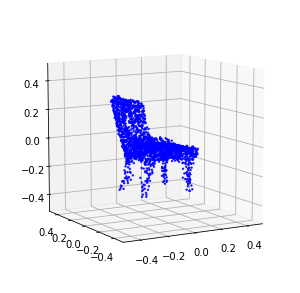

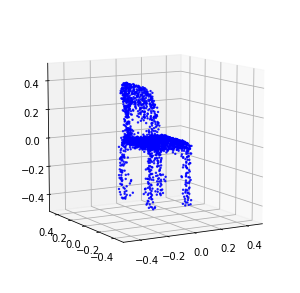

41 (1.238834595680237, 0.8437711808992469)
42 (1.2320525822432145, 0.8466015385544818)
43 (1.2415471740390944, 0.8461880523225536)
44 (1.2321746349334717, 0.8514681681342747)
45 (1.22383161627728, 0.8546516485836195)
46 (1.2189721045286759, 0.8550066963486049)
47 (1.2202145742333455, 0.8599744128144305)
48 (1.2139785279398378, 0.8655558259590812)
49 (1.2302978712579478, 0.8569867647212485)
50 (1.234285076804783, 0.8591085734574692)


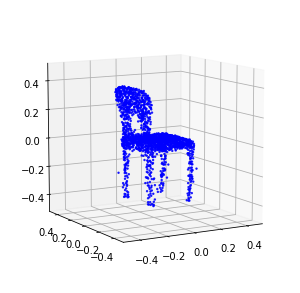

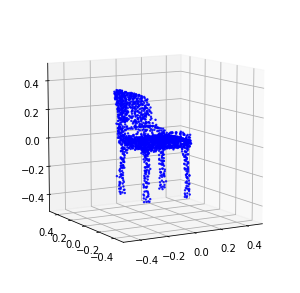

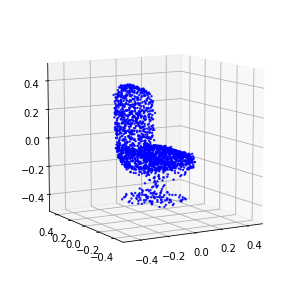

51 (1.2337391666744066, 0.8606474586155104)
52 (1.2481235929157424, 0.8520230251809825)
53 (1.2370541323786197, 0.849653652958248)
54 (1.234957076155621, 0.85211058129435)
55 (1.236315249360126, 0.8501654992932859)
56 (1.230290068750796, 0.8553741268489672)
57 (1.245570221154586, 0.8469152010005453)
58 (1.2389946771704632, 0.8485413965971573)
59 (1.2386383512745733, 0.8501237682674242)
60 (1.2457276085148687, 0.8454079208166703)


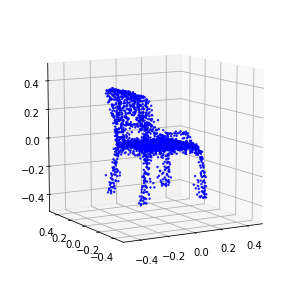

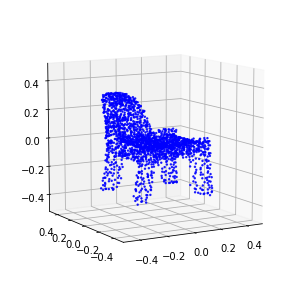

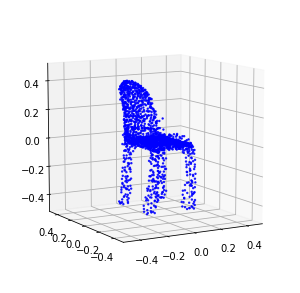

61 (1.2471510462138964, 0.8469473159831503)
62 (1.2526652636735336, 0.8400549515433934)
63 (1.2515388975972714, 0.8424954284792361)
64 (1.2571856291397758, 0.8355131817900616)
65 (1.247553416957026, 0.8440489395805028)
66 (1.240336182843084, 0.8490274869877359)
67 (1.2338788364244544, 0.8441687034524006)
68 (1.2331084437992261, 0.8520632914874865)
69 (1.2320536717124608, 0.849897927823274)
70 (1.2298632103463878, 0.8569725114366282)


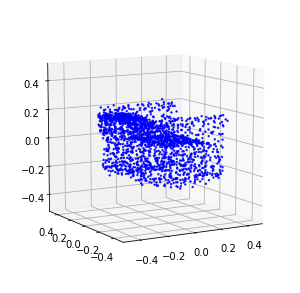

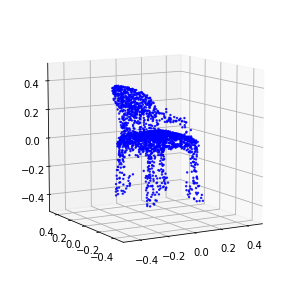

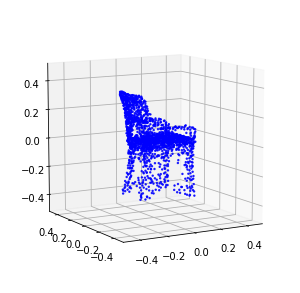

71 (1.237052841808485, 0.8528505553369937)
72 (1.2306509121604587, 0.8534641633863035)
73 (1.2336196163426274, 0.8529592083848041)
74 (1.2345507963843967, 0.856049152560856)
75 (1.2386592626571655, 0.8500799806221672)
76 (1.2348767290944638, 0.8568574708441029)
77 (1.240745733095252, 0.8567073194876961)
78 (1.2450320129809171, 0.8522309090780176)
79 (1.2406386831532354, 0.8489680212476979)
80 (1.2434617851091467, 0.8462487894555797)


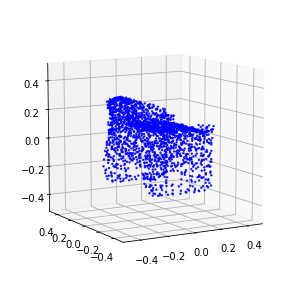

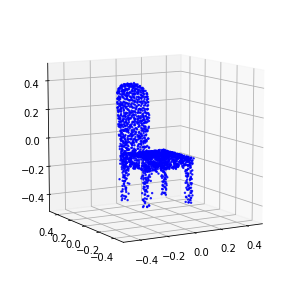

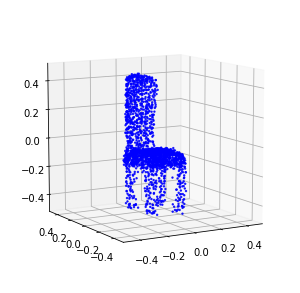

81 (1.235943248997564, 0.8516410796538644)
82 (1.2382679151452105, 0.8475350219270458)
83 (1.2356333038081293, 0.8496318915615911)
84 (1.2364831882974376, 0.8486884728721951)
85 (1.2298671608385832, 0.8590627348941305)
86 (1.2300903247750323, 0.8529014929481175)
87 (1.2329026108202727, 0.852031880357991)
88 (1.2305124065150386, 0.8553412121275197)
89 (1.2268083665681921, 0.8582798221836919)
90 (1.221693289798239, 0.8630381750023883)


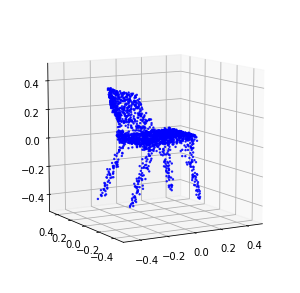

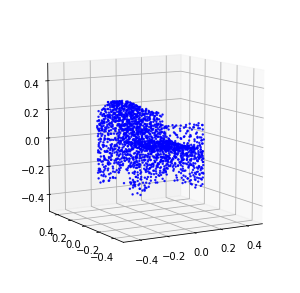

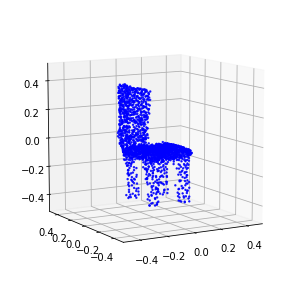

91 (1.2201023661572001, 0.8609173940575641)
92 (1.2221715792365697, 0.8658887360406958)
93 (1.2295946566954903, 0.8567960443704025)
94 (1.2192677311275317, 0.8626856389253036)
95 (1.214809629191523, 0.8696154376734858)
96 (1.213469099998474, 0.8727450821710669)
97 (1.2144140989884087, 0.8743081424547279)
98 (1.213199788591136, 0.8691834278728651)
99 (1.213595562395842, 0.8769583183786144)
100 (1.2166386790897534, 0.8700828179069188)


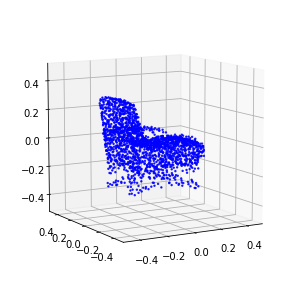

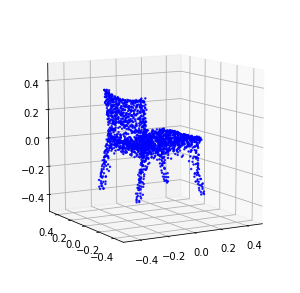

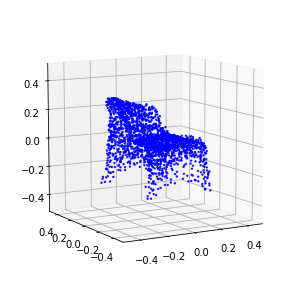

101 (1.2111612071161684, 0.8722368743108666)
102 (1.2137817517570828, 0.8771241452382958)
103 (1.2068587178769319, 0.8785955662312714)
104 (1.2098063386004905, 0.8767629291700281)
105 (1.2065152168273925, 0.8851323988126671)
106 (1.195202410739401, 0.8865099735881972)
107 (1.2030880015829335, 0.881299104379571)
108 (1.1976719078810318, 0.890189774658369)
109 (1.1933138287585714, 0.8927518150080805)
110 (1.1946510968000992, 0.8951421203820602)


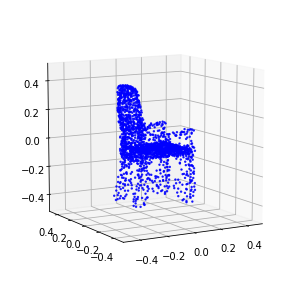

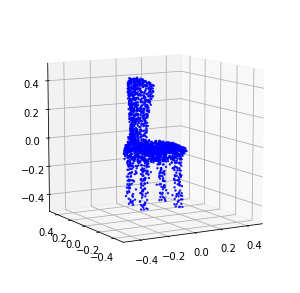

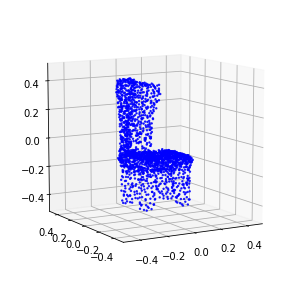

111 (1.1957660757977029, 0.8904098163480344)
112 (1.1948809623718262, 0.8919225920801578)
113 (1.189649424345597, 0.9002763038096221)
114 (1.191383054982061, 0.8982145439023557)
115 (1.1815754952638045, 0.9000351392704508)
116 (1.1791654016660607, 0.9034814326659493)
117 (1.1756548902262811, 0.9090145251025324)
118 (1.1816429438798324, 0.9072256933087888)
119 (1.1797163393186487, 0.9061302387196085)
120 (1.1799135747163192, 0.9078188885813174)


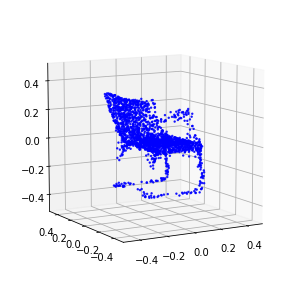

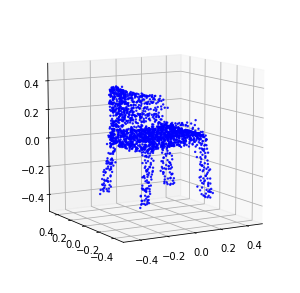

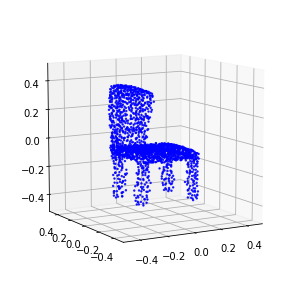

121 (1.17248593620632, 0.9151333300963692)
122 (1.1693065705506698, 0.9156425647113634)
123 (1.1732559743134872, 0.9146738689878713)
124 (1.1735618995583577, 0.9145068028698797)
125 (1.1720945907675702, 0.914985510059025)
126 (1.1717314486918242, 0.9141126757082731)
127 (1.1695500042127527, 0.9230130630990733)
128 (1.17111714300902, 0.9218423055565875)
129 (1.164263576009999, 0.920913244848666)
130 (1.1687834926273513, 0.9247835408086362)


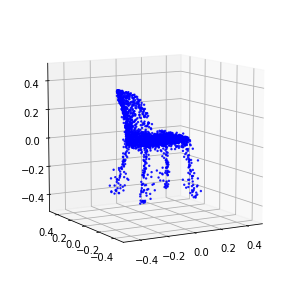

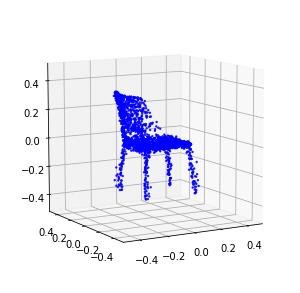

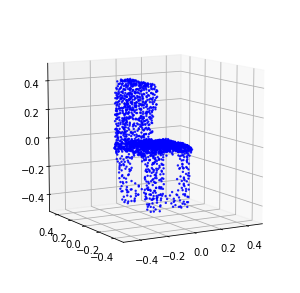

131 (1.1615602078645126, 0.9252916766249615)
132 (1.1663277968116428, 0.9259750874146171)
133 (1.162606049620587, 0.9330955774887748)
134 (1.171841928233271, 0.9267139061637547)
135 (1.1611749576485675, 0.9304970901945363)
136 (1.1626014325929726, 0.9300861026929772)
137 (1.1594914063163426, 0.9316311613373135)
138 (1.1553867029107134, 0.9340676520181739)
139 (1.1528844916302226, 0.9372053908265155)
140 (1.1575896968012271, 0.9394907339759495)


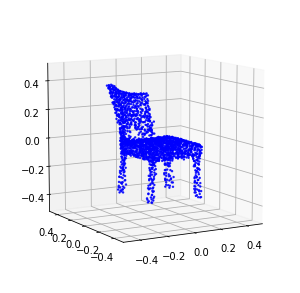

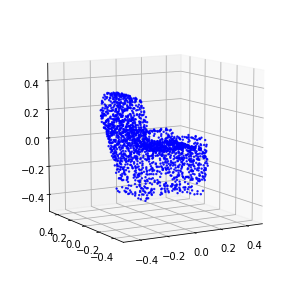

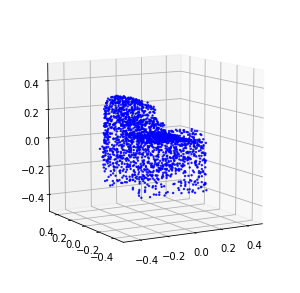

141 (1.1518574051235033, 0.9448615442151609)
142 (1.1590532043705817, 0.937616154940232)
143 (1.1525779781134233, 0.9416411140690679)
144 (1.145006729727206, 0.9521557999693829)
145 (1.1524014358935148, 0.9487719209297844)
146 (1.159027768217999, 0.945374449957972)
147 (1.1564757689185765, 0.9420125717702119)
148 (1.149454006941422, 0.9487827834875687)
149 (1.149142805389736, 0.9534965287084165)
150 (1.146173527966375, 0.9487848385520603)


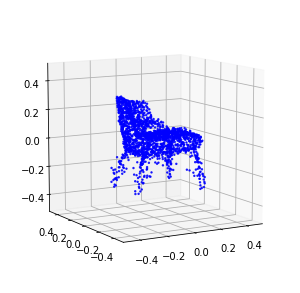

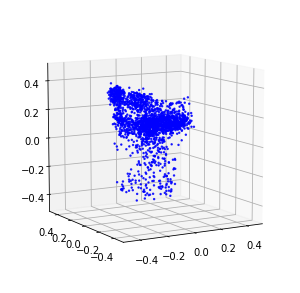

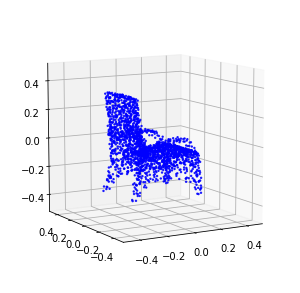

151 (1.1443229965541675, 0.952774803534798)
152 (1.1452299620794213, 0.9499864215436189)
153 (1.148952511082525, 0.9496149353359057)
154 (1.1481309092563132, 0.9533579494642175)
155 (1.1487139670745186, 0.9519083479176397)
156 (1.1504276213438616, 0.9489252738330676)
157 (1.1410685497781505, 0.9584319031756857)
158 (1.1447968954625336, 0.9599005932393281)
159 (1.15180620006893, 0.9510263422261114)
160 (1.1451775270959605, 0.9597129780313243)


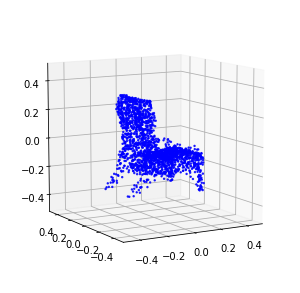

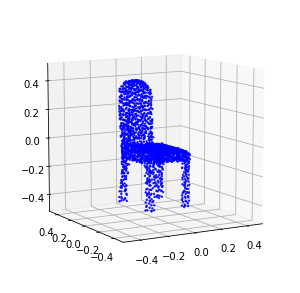

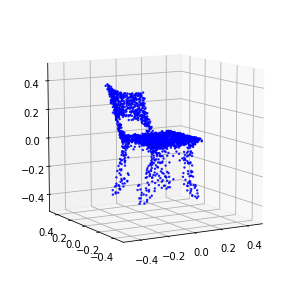

161 (1.1454110394353452, 0.9615097952925641)
162 (1.14008192912392, 0.9638508817423945)
163 (1.144433419600777, 0.9659628126932227)
164 (1.149491336034692, 0.9585134827572367)
165 (1.1393604859061863, 0.9689570515052132)
166 (1.1399180686992147, 0.9644454308178114)
167 (1.1375879282536714, 0.9704325427179751)
168 (1.1362860861031905, 0.9715541673743207)
169 (1.139980053383371, 0.9653302498485731)
170 (1.1303541131641555, 0.9699503634286963)


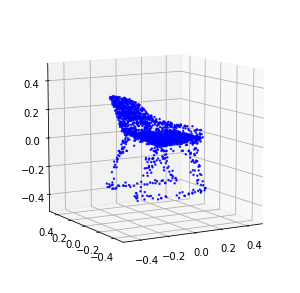

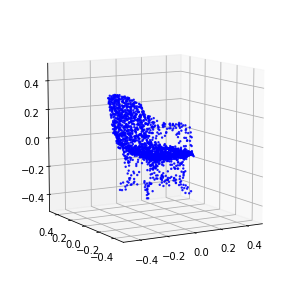

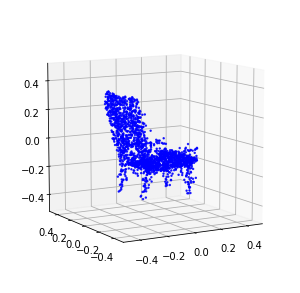

171 (1.13509049674739, 0.9749602276345958)
172 (1.1381514435229094, 0.9700265464575394)
173 (1.1376229016677193, 0.9761018167371335)
174 (1.1282887324042943, 0.9799034927202308)
175 (1.1237056421196978, 0.9809380883755892)
176 (1.1277596639550251, 0.9749215260795925)
177 (1.126162073923194, 0.9838654943134474)
178 (1.1343366669571917, 0.9779386800268423)
179 (1.1260477838308915, 0.9793216347694397)
180 (1.1302331514980481, 0.9849614977836609)


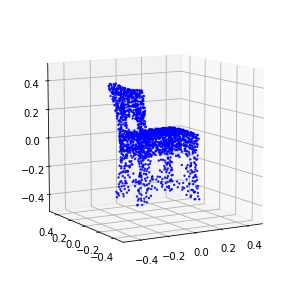

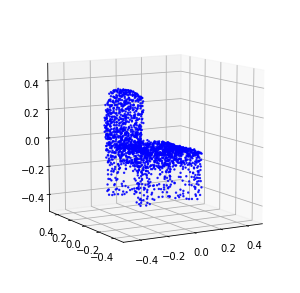

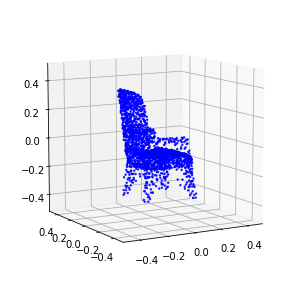

181 (1.1228080858354983, 0.9813034264937691)
182 (1.1234478079754373, 0.9842517723207889)
183 (1.1185715291811071, 0.9894267180691595)
184 (1.126965862253438, 0.9802598098049993)
185 (1.1221857050190802, 0.9854669135549794)
186 (1.1304687769516655, 0.9871040256127067)
187 (1.1178569021432296, 0.9889170439346977)
188 (1.1197572288305864, 0.9873683805051057)
189 (1.1208175368930982, 0.9922647035640219)
190 (1.1173382727996162, 0.9932679756827977)


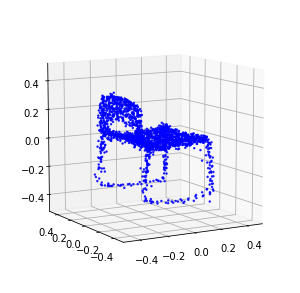

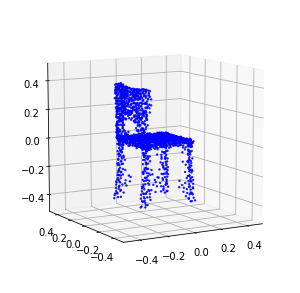

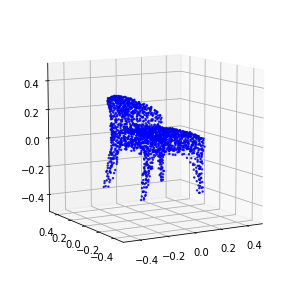

191 (1.1241522576497949, 0.9887109891228054)
192 (1.115364120317542, 0.9958523641461912)
193 (1.1174235043318375, 0.9970233544059421)
194 (1.111111108634783, 1.0005438970482867)
195 (1.1175708511601323, 1.0017243836237038)
196 (1.1121385802393373, 1.0045098206271297)
197 (1.1129020680551944, 0.9972652715185414)
198 (1.1098568268444227, 0.999388167132502)
199 (1.1166705515073694, 1.0040583418763203)
200 (1.1123510215593422, 1.0050829560860344)


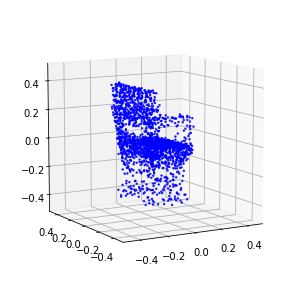

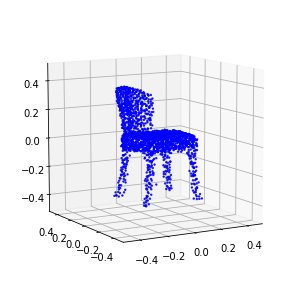

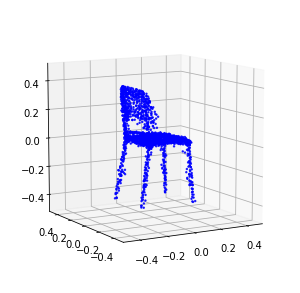

201 (1.1098381477853527, 0.9975260993708734)
202 (1.100548135715982, 1.0075498917828436)
203 (1.1020316668178725, 1.0072612270064976)
204 (1.1075733931168266, 1.0117806071820465)
205 (1.1136865491452423, 1.0070558133332626)
206 (1.109009755694348, 1.004639300574427)
207 (1.1113237842269565, 1.0014271824256233)
208 (1.1012716723525007, 1.0147136076636936)
209 (1.1101634574973065, 1.0055273481037306)
210 (1.1080113649368286, 1.002080453997073)


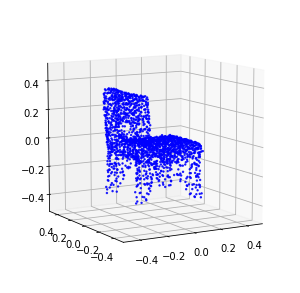

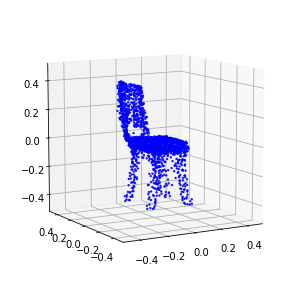

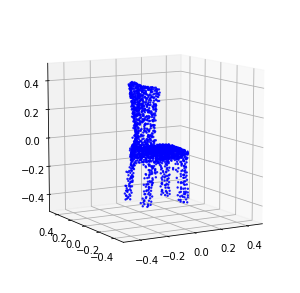

211 (1.0972503641377325, 1.0169949386430823)
212 (1.1008691502654033, 1.0102647086848384)
213 (1.0956232433733732, 1.0200411122778188)
214 (1.101603749523992, 1.015979402479918)
215 (1.093615956928419, 1.0171827705010124)
216 (1.0979487216990926, 1.0203088698179825)
217 (1.1018589030141417, 1.020825209306634)
218 (1.086211644048276, 1.0278793008431144)
219 (1.0922300867412402, 1.0233923341916955)
220 (1.091081276665563, 1.0278572927350584)


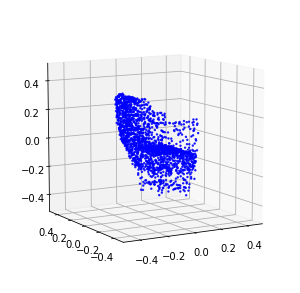

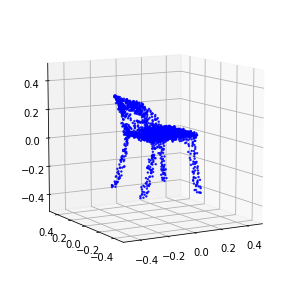

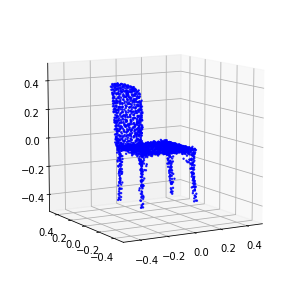

221 (1.0918134373167288, 1.0198218402655228)
222 (1.0883405970490496, 1.0257723772007485)
223 (1.0856078127156132, 1.0255156926486804)
224 (1.082923047957213, 1.0333552640417347)
225 (1.0751946335253508, 1.0359295305998428)
226 (1.0758906322976818, 1.030681316230608)
227 (1.0873127481211786, 1.02871770599614)
228 (1.0786609742952429, 1.0273916721343994)
229 (1.0795828881471052, 1.0382821051970772)
230 (1.0779362320899963, 1.034981822449228)


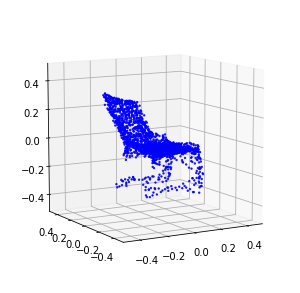

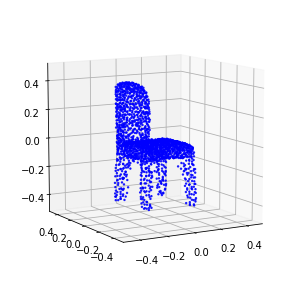

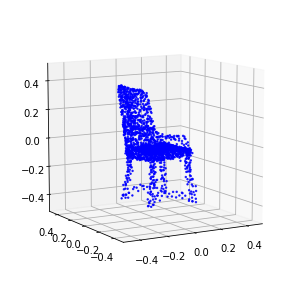

231 (1.0730067320491956, 1.0418047930883325)
232 (1.0745864427607992, 1.038314115482828)
233 (1.079619654883509, 1.0347610058991805)
234 (1.0706640590792116, 1.0400133184764697)
235 (1.0694511019665263, 1.0489040794579878)
236 (1.065998893717061, 1.044874602297078)
237 (1.068155526596567, 1.0456360651099164)
238 (1.0686948688133904, 1.0436566186987835)
239 (1.0680711549261341, 1.0477739981983019)
240 (1.0703222072642782, 1.0441622070644212)


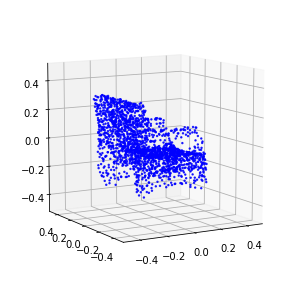

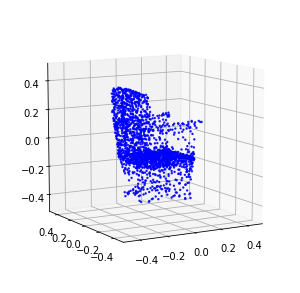

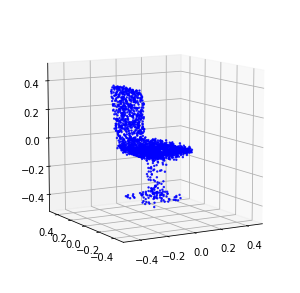

241 (1.0668960338053497, 1.0543935397396917)
242 (1.0701380651930104, 1.0542244760886483)
243 (1.0625511972800545, 1.054607243641563)
244 (1.0674959965374158, 1.051905646013177)
245 (1.0700434420419775, 1.0537621581036112)
246 (1.060371056328649, 1.0523804467657338)
247 (1.0631711343060368, 1.050099413809569)
248 (1.0627788616263347, 1.0616378618323286)
249 (1.059369591008062, 1.0589712738990784)
250 (1.0552029029182766, 1.0610506130301434)


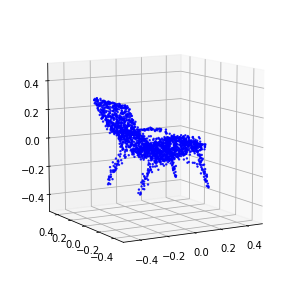

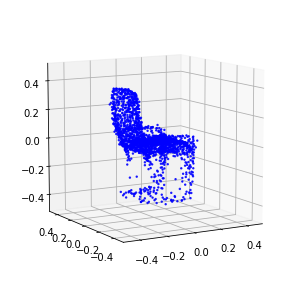

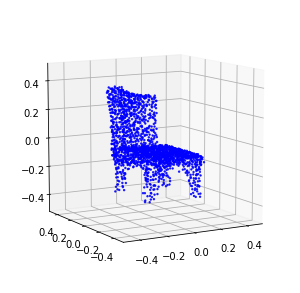

251 (1.0537432763887489, 1.0596213097157685)
252 (1.05918143313864, 1.0647540082102236)
253 (1.0660661816596986, 1.0579788456792416)
254 (1.053363151135652, 1.0580308100451594)
255 (1.0562073168547257, 1.0690284438755202)
256 (1.0542209656342216, 1.0735891601313716)
257 (1.0570853943410128, 1.0607910208080127)
258 (1.0523083194442417, 1.0652027000551638)
259 (1.0577681909436765, 1.0675482133160468)
260 (1.05649007714313, 1.064682977095894)


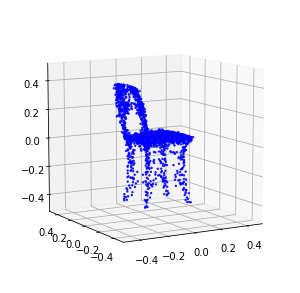

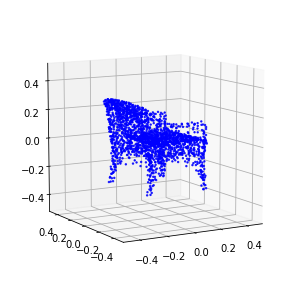

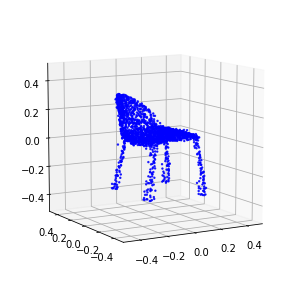

261 (1.0541615014490875, 1.0719844133957572)
262 (1.0511734257573666, 1.0665053082549054)
263 (1.0553078651428223, 1.073258846739064)
264 (1.0495534228241963, 1.0749963356100996)
265 (1.0512814547704614, 1.074640761769336)
266 (1.0500316241513128, 1.0706814330557117)
267 (1.0496064813240715, 1.0745487290879954)
268 (1.049745774269104, 1.0780037418655728)
269 (1.0478800488554914, 1.0749517741410628)
270 (1.0465156337489252, 1.0749788885531217)


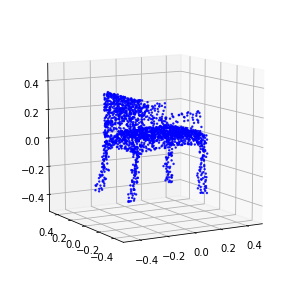

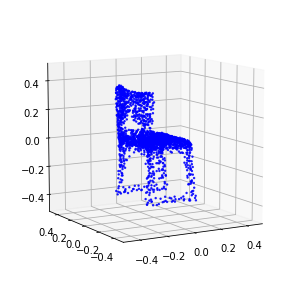

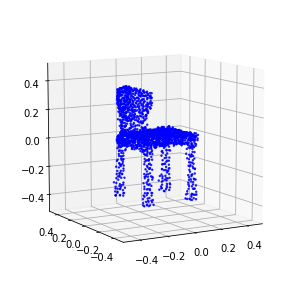

271 (1.048840456423552, 1.0796600020450093)
272 (1.0491758248080378, 1.0788678837859111)
273 (1.0508858587430872, 1.0752318071282427)
274 (1.0454616919807767, 1.0790961130805639)
275 (1.0447092564209648, 1.075771519412165)
276 (1.0468394103257552, 1.0775315186251764)
277 (1.0404473076695981, 1.0822592191074205)
278 (1.0358459659244703, 1.0868018720460975)
279 (1.0337961051775062, 1.085018142928248)
280 (1.038868891156238, 1.0859290915986766)


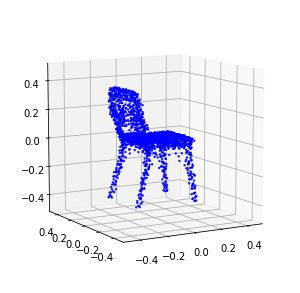

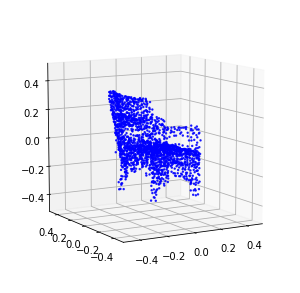

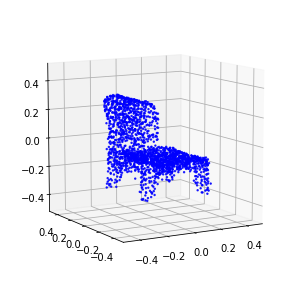

281 (1.0424472658530526, 1.0851637964663299)
282 (1.0388739300810772, 1.0905745817267376)
283 (1.0431772936945376, 1.0905142727105515)
284 (1.0361840268839961, 1.0922166658484418)
285 (1.042726038849872, 1.0933635421421217)
286 (1.0350137938623842, 1.0926292248394178)
287 (1.0312656853509985, 1.0896947705227396)
288 (1.0270427823066712, 1.1026756670164026)
289 (1.0344347855319147, 1.09680684649426)
290 (1.0255475640296936, 1.100416680522587)


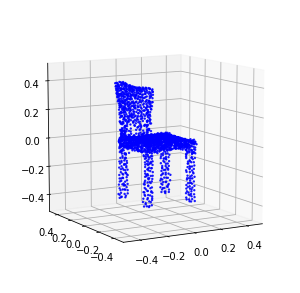

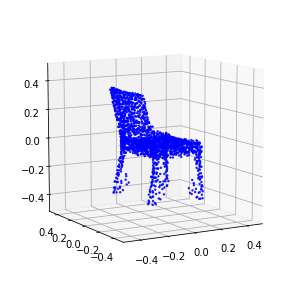

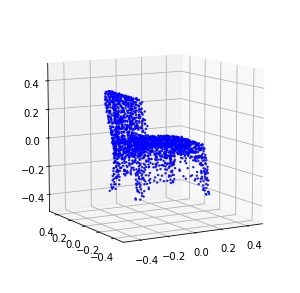

291 (1.0342732533164647, 1.1011382242907648)
292 (1.029901230853537, 1.0954352933427562)
293 (1.024403610955114, 1.1008763909339905)
294 (1.027506028569263, 1.1040543571762416)
295 (1.0309917983801469, 1.1007160839827164)
296 (1.019349045338838, 1.1037607830503713)
297 (1.021973591265471, 1.1094047758890235)
298 (1.0191587981970414, 1.1070744333059892)
299 (1.02405591270198, 1.1106220074321913)
300 (1.0154107150824174, 1.1161796409150828)


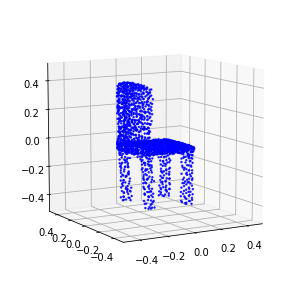

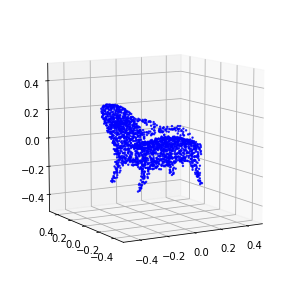

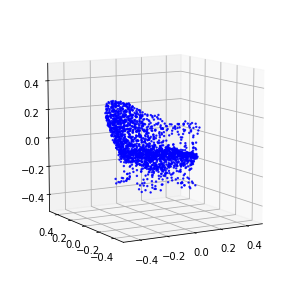

301 (1.0165221463079037, 1.1102470491243446)
302 (1.0136018753051759, 1.1160731668057648)
303 (1.0222880156143852, 1.1118643050608428)
304 (1.017054627770963, 1.111419723863187)
305 (1.0128220858781234, 1.1132708694623865)
306 (1.0130880837855132, 1.1199701858603437)
307 (1.0108291574146437, 1.1221563634665117)
308 (1.0093167387920878, 1.1253561864728514)
309 (1.010312881677047, 1.124045067248137)
310 (1.0072202060533606, 1.126785153409709)


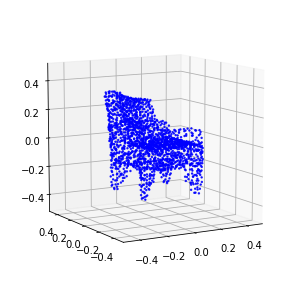

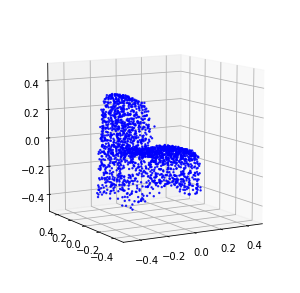

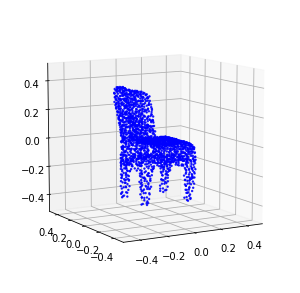

311 (1.0100695003633913, 1.1217768928279048)
312 (1.0072463113328685, 1.1290612557659978)
313 (1.0031539678573609, 1.1302165223204572)
314 (1.0011919239292975, 1.1259833113006923)
315 (1.0040867416755013, 1.1307275062022002)
316 (1.0050319365833116, 1.1296145076337067)
317 (1.007009750345479, 1.1313042873921602)
318 (0.9984037902044214, 1.1319974469101948)
319 (0.9997386051260907, 1.1331520433011262)
320 (1.0015916098719058, 1.1314704542574676)


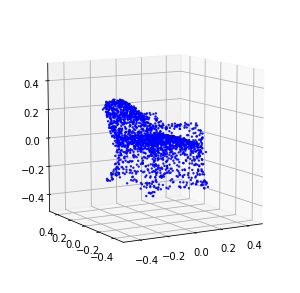

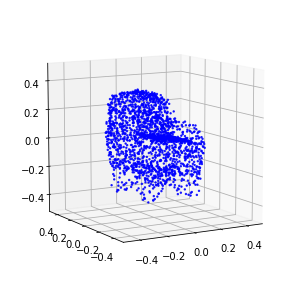

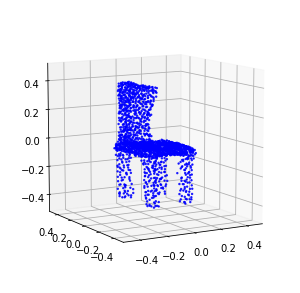

321 (0.9956881657890652, 1.1366766644560773)
322 (1.0012583115826483, 1.131926939798438)
323 (1.0081569697545922, 1.124627813567286)
324 (0.9963996866474981, 1.1369739967843762)
325 (0.9952532239582228, 1.1434456301772076)
326 (0.9973226448763972, 1.1480243900547857)
327 (0.9945596710495327, 1.1425016040387361)
328 (0.9959291136783103, 1.1381429864012678)
329 (0.9910842418670655, 1.13943618328675)
330 (0.9918447074682816, 1.1485098745511926)


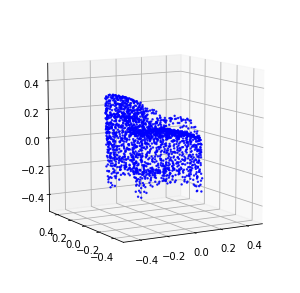

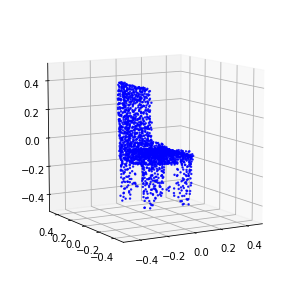

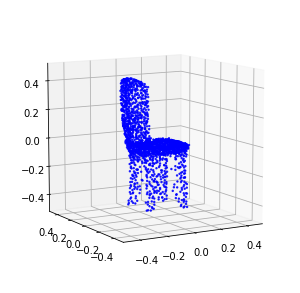

331 (0.9936242912126624, 1.1416609219882798)
332 (0.9952922810678897, 1.1445184614347375)
333 (0.9926046827565069, 1.1544651145520417)
334 (0.9887262510216754, 1.1391481783079065)
335 (0.9884788984837739, 1.1554611123126486)
336 (0.9956435581912165, 1.1445826146913611)
337 (0.9920249565787937, 1.147338344739831)
338 (0.9838589160338692, 1.1558306818423063)
339 (0.9867565429728964, 1.155169573555822)
340 (0.9799579335295636, 1.1568236801935279)


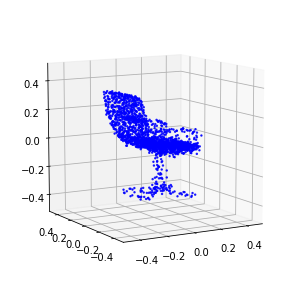

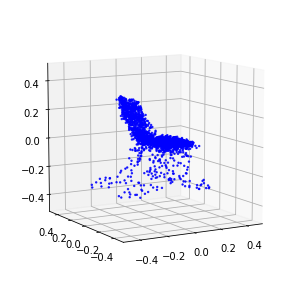

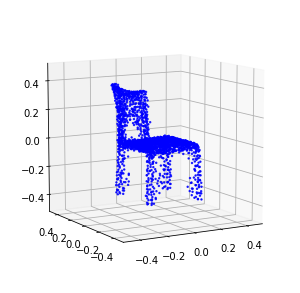

341 (0.9886290353277455, 1.1484030013499054)
342 (0.9843230952387271, 1.1602191137230915)
343 (0.9792257241580797, 1.1581156393756038)
344 (0.9769038086352141, 1.1617551357849785)
345 (0.9846378627030746, 1.1620567301045293)
346 (0.9848296077355094, 1.162736611780913)
347 (0.9790042685425799, 1.1594291572985442)
348 (0.9801722277765689, 1.1610052202058876)
349 (0.9764210820198059, 1.1658372293347898)
350 (0.9760355436283609, 1.1630662228750146)


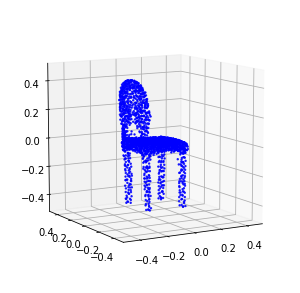

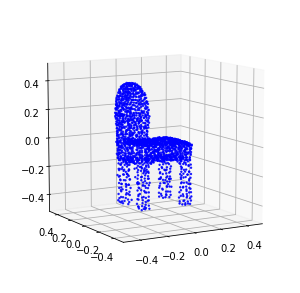

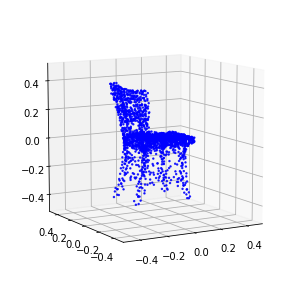

351 (0.9660279517588408, 1.176892247925634)
352 (0.9755111129387565, 1.1698251470275547)
353 (0.9698305679404218, 1.1715058290440103)
354 (0.9677545936211296, 1.1817111502523008)
355 (0.9744354227314824, 1.1745381889135942)
356 (0.9721493109412815, 1.1756034897721332)
357 (0.9701107465702554, 1.1754736065864564)
358 (0.9703369171723075, 1.1780984754147736)
359 (0.9679699192876401, 1.178583234289418)
360 (0.9647384145985479, 1.1851681880328966)


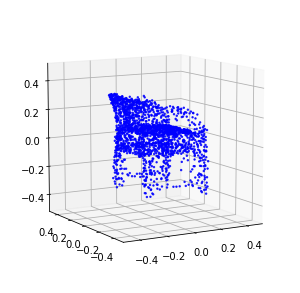

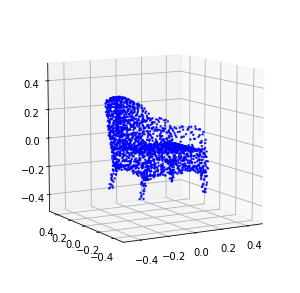

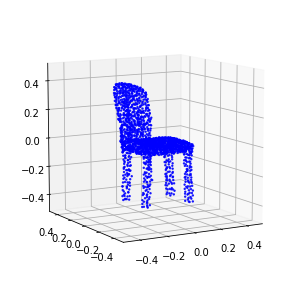

361 (0.9696816833122917, 1.1779383146244546)
362 (0.9635425292927285, 1.1804724382317584)
363 (0.9729084341422372, 1.181969516173653)
364 (0.9643123585244884, 1.1856423124023105)
365 (0.961270769264387, 1.1840234087861103)
366 (0.9634690191434777, 1.1957505744436512)
367 (0.952743445272031, 1.1844983525898145)
368 (0.9591322634531104, 1.195429969870526)
369 (0.9602235762969308, 1.1840735150420147)
370 (0.9537089461865632, 1.1908352530520896)


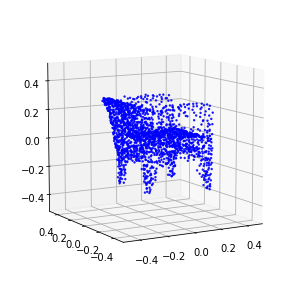

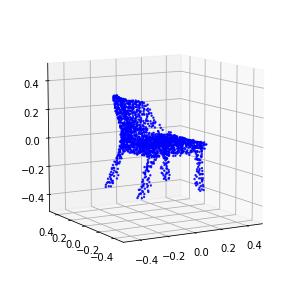

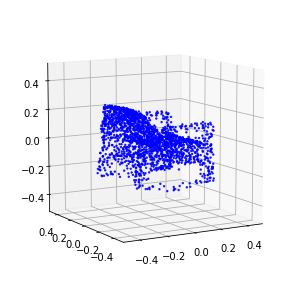

371 (0.958400151003962, 1.1923361716063126)
372 (0.9584648966789245, 1.1962767963824066)
373 (0.9621294643567956, 1.1874846836794977)
374 (0.955758097379104, 1.1878274948700616)
375 (0.9571546953657399, 1.1927386444547903)
376 (0.9497502705325251, 1.1993511142938034)
377 (0.9592313553975976, 1.1971562774285027)
378 (0.9556078449539517, 1.201183940016705)
379 (0.94708136268284, 1.199430232980977)
380 (0.9530212811801745, 1.2094208105750706)


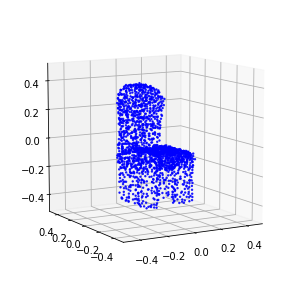

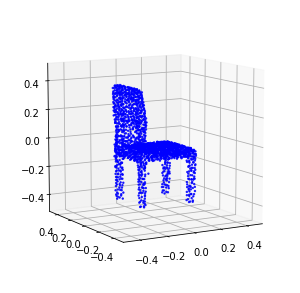

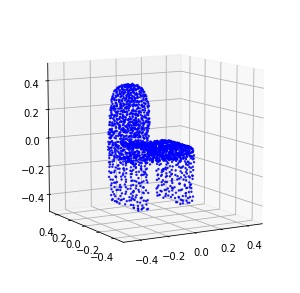

381 (0.9490152125773222, 1.2082503961480182)
382 (0.9447441329126772, 1.2093298544054445)
383 (0.9508194482844808, 1.2060329872628917)
384 (0.9524074906888216, 1.2006761302118716)
385 (0.9502158735109412, 1.2034024953842164)
386 (0.9487375808798748, 1.2049317131871762)
387 (0.9513660415359165, 1.2015388499135558)
388 (0.9521883498067442, 1.2011091170103654)
389 (0.9448320264401643, 1.2029741012531778)
390 (0.9401058114093283, 1.2115951745406441)


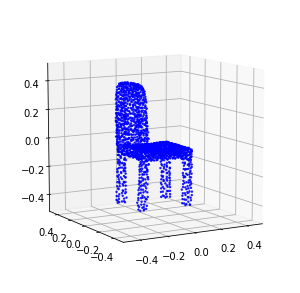

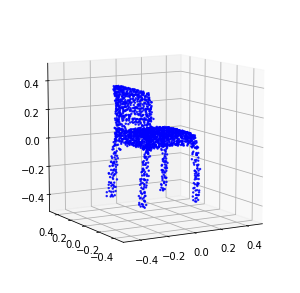

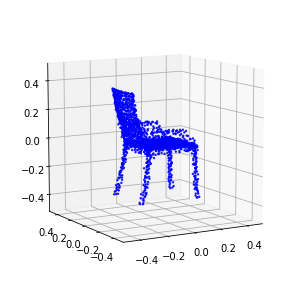

391 (0.9447549358658168, 1.201859286038772)
392 (0.9459973433743353, 1.2093343460041543)
393 (0.9490780182506727, 1.2093958626622738)
394 (0.9527647852897644, 1.2042343098184336)
395 (0.9467408833296402, 1.2111854594686757)
396 (0.9362468988999076, 1.222696692528932)
397 (0.9405470257220061, 1.2122177994769552)
398 (0.9400072802668032, 1.215886269963306)
399 (0.9404503557993018, 1.2204049037850422)
400 (0.9451392909754878, 1.2174560961516008)


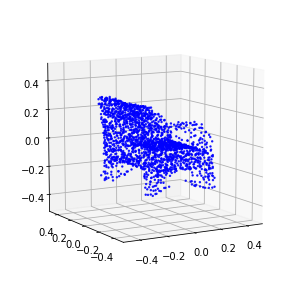

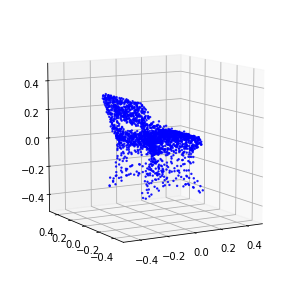

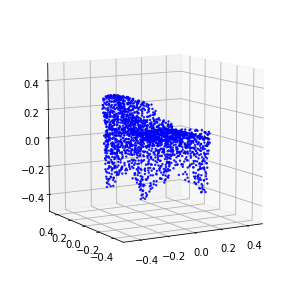

401 (0.9382339731506679, 1.2207950731982355)
402 (0.9413298917853314, 1.208826986603115)
403 (0.9296793875486954, 1.2209989900174347)
404 (0.9357473228288733, 1.2244549611340398)
405 (0.9479196626207103, 1.2167005647783693)
406 (0.9401482986367267, 1.2266961476077205)
407 (0.9355503927106442, 1.225400866114575)
408 (0.9377584815025329, 1.2189024168512095)
409 (0.9417146672373232, 1.2281627012335736)
410 (0.937841550681902, 1.2241835148438163)


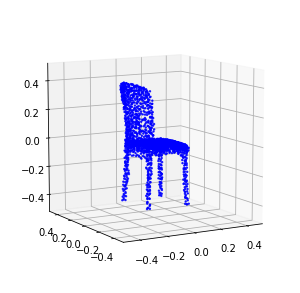

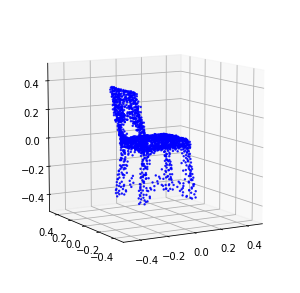

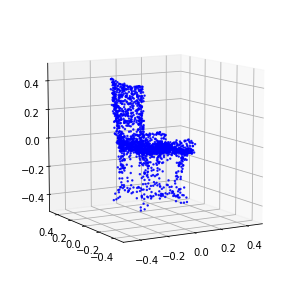

411 (0.9348274738892265, 1.224836191923722)
412 (0.9311354720074198, 1.2329791597698045)
413 (0.9284920049750287, 1.2263338638388592)
414 (0.9298328876495361, 1.2329604983329774)
415 (0.9366529355878416, 1.2271337037501129)
416 (0.9319973717565122, 1.2294329311536707)
417 (0.9255276348279871, 1.2375021157057389)
418 (0.9320231240728627, 1.234526347077411)
419 (0.9293199228203814, 1.2332892993222113)
420 (0.9268375417460566, 1.2436014771461488)


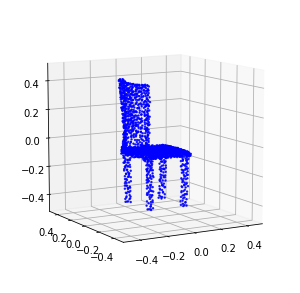

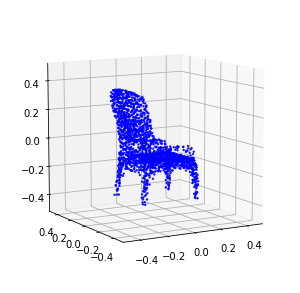

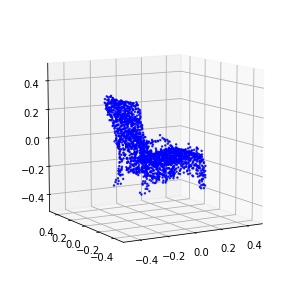

421 (0.9312354735706163, 1.2394171517828236)
422 (0.931926211066868, 1.2205270673917687)
423 (0.928250949797423, 1.239959318741508)
424 (0.9274647277334462, 1.2334496524022973)
425 (0.9267039977985879, 1.2460221627484198)
426 (0.9329400777816772, 1.236508824514306)
427 (0.9235771199931269, 1.248232991280763)
428 (0.9230786504952804, 1.2453580680100813)
429 (0.928543193962263, 1.241164669783219)
430 (0.9268427600031314, 1.2414974596189416)


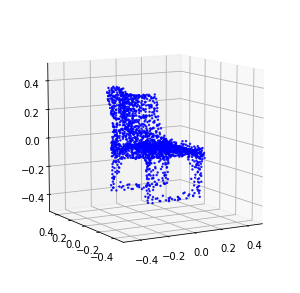

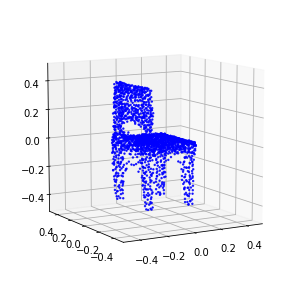

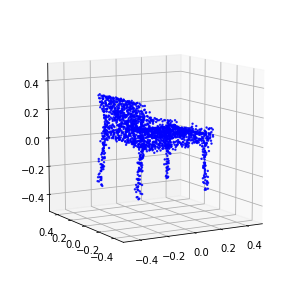

431 (0.926176991670028, 1.2420581081639166)
432 (0.9265692410261734, 1.2498438695202703)
433 (0.9208833875863448, 1.245169376808664)
434 (0.9220831274986268, 1.2504123599632926)
435 (0.9225073715914851, 1.242989404823469)
436 (0.9149987573209016, 1.249842055465864)
437 (0.9174062702966773, 1.2503594014955604)
438 (0.9249124112336532, 1.249204437110735)
439 (0.912473219892253, 1.267891536069953)
440 (0.9136726571165997, 1.256827974319458)


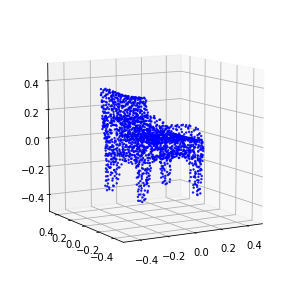

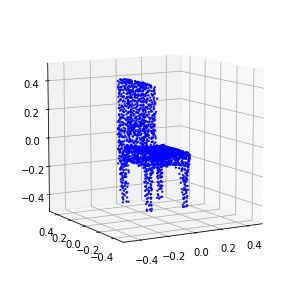

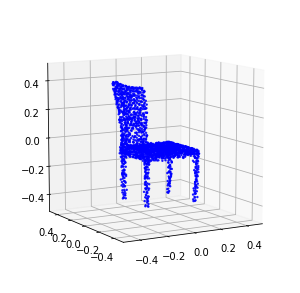

441 (0.9221141623414081, 1.2609776128893313)
442 (0.9162077940028647, 1.2472660329030907)
443 (0.9102046925088634, 1.2555608998174252)
444 (0.9156316223351851, 1.2538545214611552)
445 (0.9077774016753487, 1.260829041833463)
446 (0.9105001941971157, 1.2644799237665922)
447 (0.9202104428540105, 1.2515241882075434)
448 (0.9115858990213145, 1.2576441650805266)
449 (0.9146071864211041, 1.2649826490360758)
450 (0.9187062455260235, 1.258271516924319)


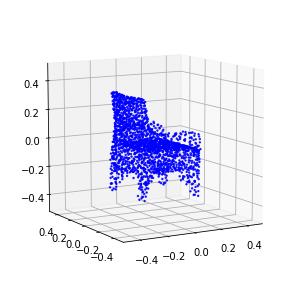

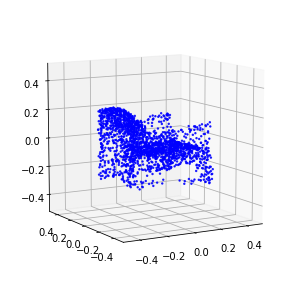

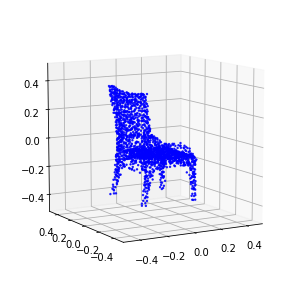

451 (0.9179524442423945, 1.2586454401845517)
452 (0.9103240982345913, 1.2662228568740512)
453 (0.9186804165010867, 1.2553223599558292)
454 (0.9156846663226252, 1.2637903814730438)
455 (0.9121632612269858, 1.2703756783319555)
456 (0.9099067314811374, 1.2583706835041875)
457 (0.9055105266363724, 1.2730961364248525)
458 (0.9094072440396185, 1.2653612613677978)
459 (0.9077245520508808, 1.2664863187333812)
460 (0.9067620210025622, 1.273408709919971)


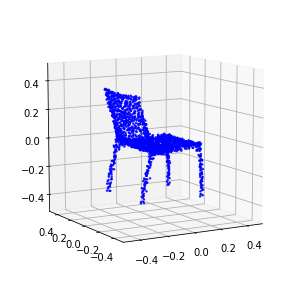

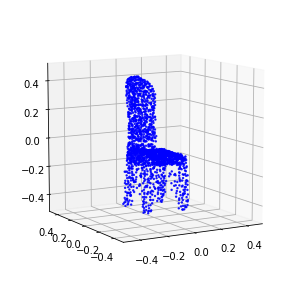

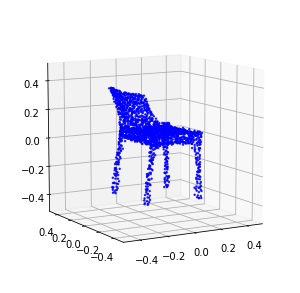

461 (0.9135713385499042, 1.2734673743662628)
462 (0.9016594083412833, 1.267735263057377)
463 (0.9019592451012652, 1.2743982688240383)
464 (0.9072308301925659, 1.2771833165832187)
465 (0.9066925162854402, 1.2833815097808838)
466 (0.8953049716742142, 1.2747264369674352)
467 (0.8955579612566077, 1.2811618727186451)
468 (0.9041706484297047, 1.2818731670794279)
469 (0.8990711574969085, 1.2755176088084346)
470 (0.9004939587219901, 1.2803372720013495)


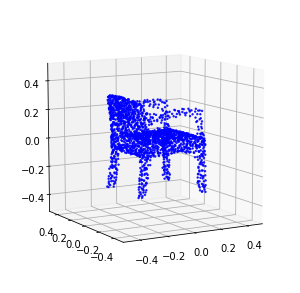

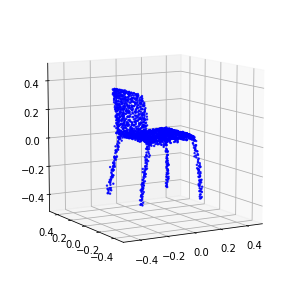

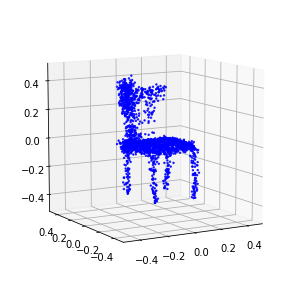

471 (0.8952181888663251, 1.2775691172351007)
472 (0.8948080861050149, 1.2871868822885597)
473 (0.9015236476193303, 1.2841229392134625)
474 (0.8958950395169465, 1.2853337469308272)
475 (0.8974088181620059, 1.2800665627355161)
476 (0.8993015159731326, 1.276325706295345)
477 (0.8988802920217099, 1.2830805726673291)
478 (0.903399033650108, 1.27444290233695)
479 (0.8981753074604532, 1.2853786577349124)
480 (0.9071945491044417, 1.2828710794448852)


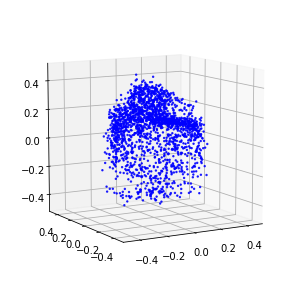

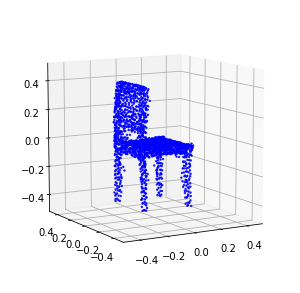

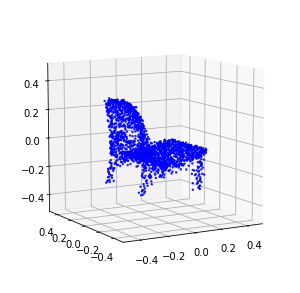

481 (0.8982337319332621, 1.282954065696053)
482 (0.9008418938387995, 1.281937667079594)
483 (0.8962102506471716, 1.2831000908561374)
484 (0.9005976029064344, 1.29069641828537)
485 (0.8945221776547639, 1.2925080050592836)
486 (0.8980516506277997, 1.2853319997372834)
487 (0.8796760543532993, 1.2961223488268645)
488 (0.8975165133890899, 1.2891979761745618)
489 (0.8870316541713217, 1.3019749869471011)
490 (0.8955378200696862, 1.2934982973596325)


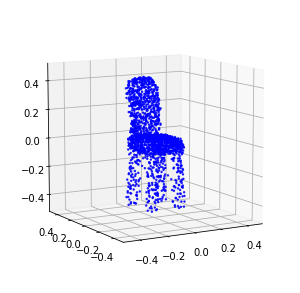

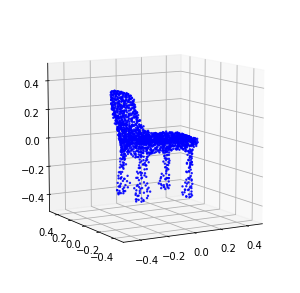

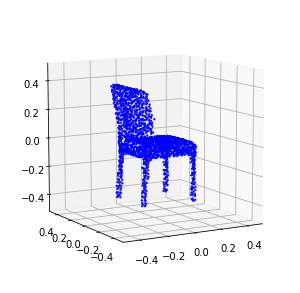

491 (0.8954076233117477, 1.2931428945582846)
492 (0.8906221700751263, 1.296703002763831)
493 (0.8844544840895612, 1.293770250030186)
494 (0.8847706447476926, 1.307473792200503)
495 (0.8941008142803026, 1.2938565352688665)
496 (0.890841413580853, 1.296152815093165)
497 (0.8880808125371519, 1.2958521573439887)
498 (0.8800226310025091, 1.3048225915950278)
499 (0.886004912853241, 1.3148435742958733)
500 (0.8860593655835027, 1.3018768087677333)


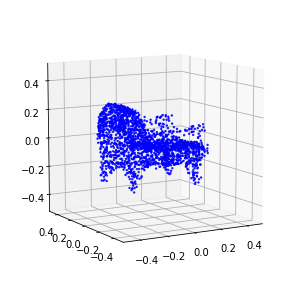

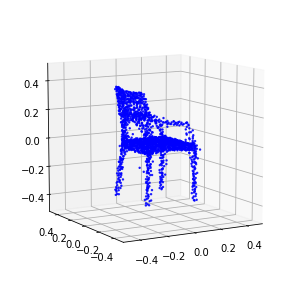

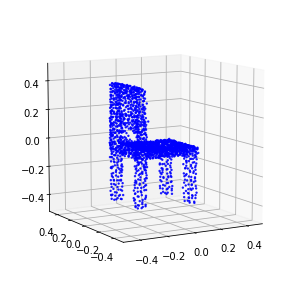

In [42]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
                
        if epoch % 10 == 0:
            syn_latent_data = gan.generate(3, noise_params)
            syn_data = ae.decode(syn_latent_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot()
        
        
#         if save_model and (epoch % saver_step == 0 or epoch <= 5):
#             checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
#         if save_synthetic_samples and epoch in saver_step:
#             syn_latent_data = gan.generate(n_syn_samples, noise_params)
#             syn_data = ae.decode(syn_latent_data)
#             np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
#             for k in range(3):
#                 Point_Cloud(syn_data[k]).plot()
            
#         train_stats.append((epoch,) + loss)

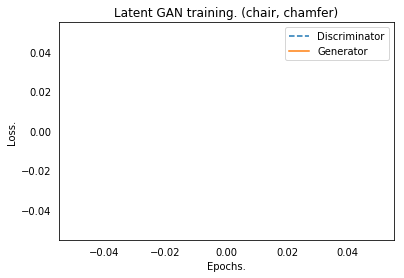

In [43]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')